In [31]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models.misgen import InterpretableImpalaModel
from models.policy import CategoricalPolicy
import torch
from IPython import display

building procgen...done


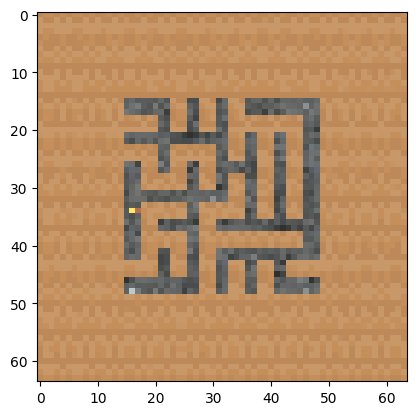

In [4]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=1, env_name='maze', num_levels=1, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Move the cheese

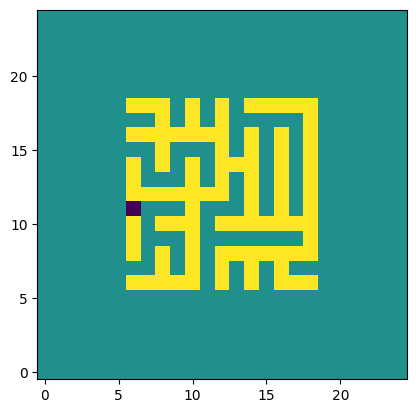

In [5]:
state_bytes = venv.env.callmethod("get_state")[0] # first in venv
state_vals = maze.parse_maze_state_bytes(state_bytes)
grid = maze.get_grid(state_vals)
cheese_row, cheese_col = maze.get_cheese_pos(grid)
plt.imshow(grid, origin='lower')

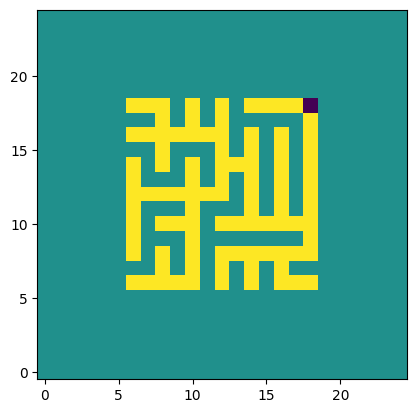

In [6]:
maze.set_cheese_pos(grid, 18, 18)
plt.imshow(grid, origin='lower')

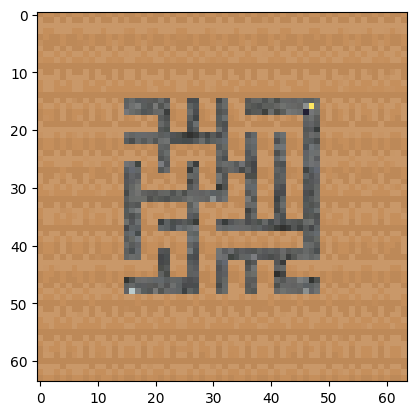

In [7]:
maze.set_grid(state_vals, grid)
state_bytes = maze.serialize_maze_state(state_vals)
venv.env.callmethod("set_state", [state_bytes])

obs = venv.reset()
plt.imshow(obs[0].transpose(1, 2, 0))

## Run the model on the new maze

In [ ]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [8]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
checkpoint = torch.load('model_200015872.pth', map_location=torch.device('cpu'))

In [9]:
model = InterpretableImpalaModel(in_channels=3)

policy = CategoricalPolicy(model, action_size=venv.action_space.n)
policy.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

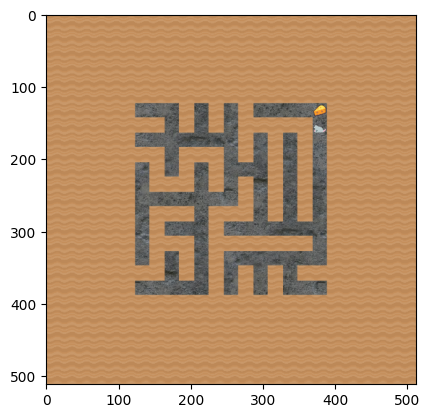

In [29]:
done = np.zeros(venv.num_envs)
obs = venv.reset()

while not all(done):
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    obs, rew, done, info = venv.step(act)

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        plt.imshow(info[0]['rgb'])
        display.display(plt.gcf())
        display.clear_output(wait=True)